In [1]:
from utils.codification_cnn import ChromosomeCNN, CNNLayer, NNLayer, FitnessCNN
from utils.codifications import Fitness
from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager

from time import time


Using TensorFlow backend.


In [4]:
ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.3
generations = 30
population = 20
train_time = 60
maximize_fit = False
stat_val=False
folder = "../delete"
save_progress = False
p = ps[parents_selector_key]



fitness = FitnessCNN()
l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness)

# Fitness params
epochs = 75
batch_size = 128
verbose = 1
redu_plat = False
early_stop = True
warm_up_epochs= 5
base_lr = 0.001
smooth = 0.1
cosine_dec = False

# dataset params:
dataset = 'MRD'
data_folder = '../../../../../datasets/MNIST_variations'
classes = []

# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, epochs=epochs, cosine_decay=cosine_dec,
                   early_stop=early_stop, warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)



generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                             save_progress=save_progress)

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples
Genetic algorithm params
Number of generations: 30
Population size: 20
num parents: 6
offspring size: 14



CNN|F:32|K:(3,3)|A:relu|D:0.000|M:0
CNN|F:64|K:(3,3)|A:relu|D:0.250|M:1
NN|U:128|A:relu|D:0.500
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
__________________________________

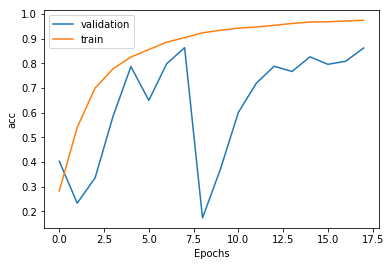

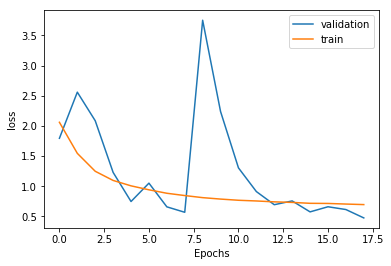

0.1363 in 3.0 min



0.1362500007947286

In [6]:
c.fitness()

In [ ]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)


In [ ]:
generational = GenerationalGA.load_genetic_algorithm(folder=folder)

In [ ]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)

In [8]:
l1 = CNNLayer(104, (5,3), 'prelu', 0.046, True)
l2 = CNNLayer(132, (1,1), 'leakyreLu', 0.597, 0)
l3 = CNNLayer(127, (5,5), 'prelu', 0.286, 1)
l4 = CNNLayer(104, (3,4), 'relu', 0.346, 1)
l5 = CNNLayer(160, (5,1), 'sigmoid', 0.413, 1)
l6 = NNLayer(118, 'elu', 0.354)
best = Cromosome([l1,l2,l3,l4,l5], [l6])

l1_ = CNNLayer(32, (3,3), 'relu', 0.2, False)
l2_ = CNNLayer(64, (3,3), 'relu', 0.2, True)
l3_ = NNLayer(128, 'relu', 0.5)
base = Cromosome([l1_, l2_], [l3_])

nn = Cromosome([],[NNLayer(830, 'prelu', 0.654), NNLayer(782, 'tanh', 0.166), NNLayer(28, 'elu', 0.062)])

CNN|F:32|K:(3,3)|A:relu|D:0.200|M:0
CNN|F:64|K:(3,3)|A:relu|D:0.200|M:1
NN|U:128|A:relu|D:0.500
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
__________________________________

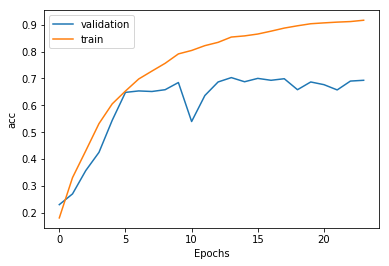

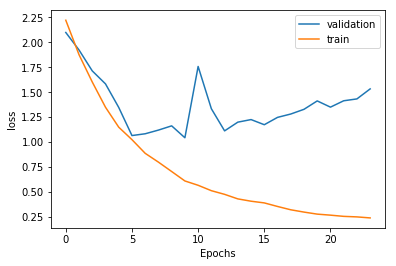

0.2967 in 1.7 min



In [11]:
s = fitness.calc(base, lr=0.001, test=True)